Theoretical orbit response to kick $\theta$:

$$C_{ij} = \theta_i \frac{ \sqrt{\beta_i \beta_j}}{2 \sin{\pi Q}} \cos(  2 \pi | \mu_i - \mu_j| - \pi Q) + \frac{\eta_i \eta_j}{\left( \alpha_C - \frac{1}{\gamma^2}\right) C}$$

LOCO needs to compute

$$M_x = \frac{\partial^2 x_i}{\partial \theta_j \partial k_{1,m}}$$
$$M_y = \frac{\partial^2 y_i}{\partial \theta_j \partial k_{1,m}}$$

where $\{\theta_j\}$ are orbit correctors hor. and vert.

and

$\{ k_{1,m}\}$ are quadrupole normal and skew used for correction, as many as there are power supplies

input:
perturb.param or script generating same
...

In [1]:
print(f"LOCO, AT version")
from at import *
from pylab import *
from AT_ORM import *
from at.load import load_mat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from random import random

LOCO, AT version


In [2]:
# The lattice

from lattice3 import *
#ring = [B1H, CXY01, DD, BPM, QF,SF, DD, B1H, B1H, CXY02, DD, BPM, QD, DD, B1H, m0]
ring=at.Lattice(ring, energy=1)
ring.radiation_off()

preparing twiss ..
Tunes=[0.35830786 0.36002871]
Chrom=[-2.65974451 -1.92722258]


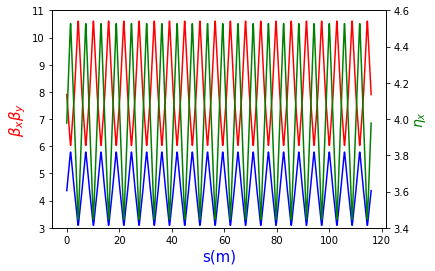

In [3]:
elements_indexes = get_refpts(ring, elements.Monitor)
twiss = getOptics(ring, '*', 'beta', 'False')

(40, 40)


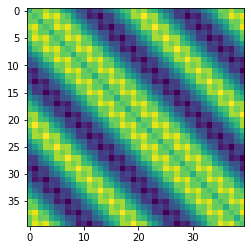

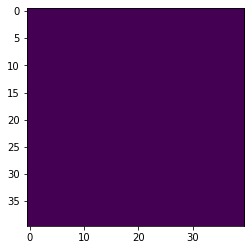

In [4]:
Cxx, Cxy= ORM_x(1.e-4, ring)
Cyy, Cyx= ORM_y(1.e-4, ring)

print(shape(Cxx))

plt.figure()
imshow(Cyy)
plt.show()

plt.figure()
imshow(Cyx)
plt.show()


In [5]:
quads_info = quad_info(ring)

Done...


In [6]:
quad_dict,quad_vals = getQuadFamilies(quads_info)
quads = [ k for k in quad_dict.keys()]
print(f"Quadrupoles:{quads}")
iq = 1
print(quads[iq], quad_dict[quads[iq]])
print(quad_vals[quads[iq],4])
print(quad_vals[quads[iq],0])
eocc_a, vals = getQuadFamilies(quads_info)
print(eocc_a)
print(quad_vals[quads[iq],0])

Quadrupoles:['QF', 'QD']
QD 19
-2.1
-2.1
{'QF': 19, 'QD': 19}
-2.1


In [7]:
def computeOpticsD(ring, qname, i, dk):

    bpm_indexes = get_refpts(ring, elements.Monitor)
    quad_indexes = get_refpts(ring, qname)

    ring[quad_indexes[i]].K =  quad_vals[qname,i] + dk

    qxx, qxy= ORM_x(1.e-4, ring)
    qyy, qyx= ORM_y(1.e-4, ring)

    ring[quad_indexes[i]].K = quad_vals[qname,i]
    print(ring[quad_indexes[i]].K)

    return  qxx, qxy, qyy, qyx

In [8]:
%%time
# sequential version, this takes long:
# optimize with parallelization and separate function
# prepare

dk = 0.0001
qxx = []
qxy =[]
qyy = []
qyx =[]
quad_names = quads
for qname in quad_names:
    print('generating response to {}, n={}'.format(qname, quad_dict[qname]))
    nq = quad_dict[qname]+1
    for i in range(0,nq):
       Qxx, Qxy, Qyy, Qyx = computeOpticsD(ring, qname,i, dk)
       qxx.append(Qxx)
       qxy.append(Qxy)
       qyy.append(Qyy)
       qyx.append(Qyx)

generating response to QF, n=19
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
generating response to QD, n=19
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
Wall time: 48.7 s


In [9]:
from loco import getTheorOrm, getOrm
from pylab import *

C0x = Cxx
C0y = Cyy
C0xy = Cxy
C0yx = Cyx

dCx = []
dCy = []
dCxy = []
dCyx = []
quad_names = quads
for qname in quad_names:
    nquad = quad_dict[qname]
    print('loading response to:',qname)
    for i in range(0,nquad+1):

        C1x = qxx[i]
        C1y = qyy[i]
        C1xy = qxy[i]
        C1yx = qyx[i]

        dCx.append( (C1x-C0x)  / dk)
        dCy.append( (C1y-C0y) /dk)
        dCxy.append( (C1xy-C0xy)/ dk)
        dCyx.append( (C1yx-C0yx)/ dk)

loading response to: QF
loading response to: QD


In [13]:
## simulate_errors

In [10]:
errorQF = 72.e-3 #0.01
errorQD = 52.e-3 #0.01
tiltQF = 0.0003
tiltQD = 0.0003

quads_info_error = simulateError(ring,errorQF,errorQD)

simulating perturbed machine...
Done...


preparing twiss ..
Tunes=[0.39337012 0.38167188]
Chrom=[-2.71132261 -1.99684959]


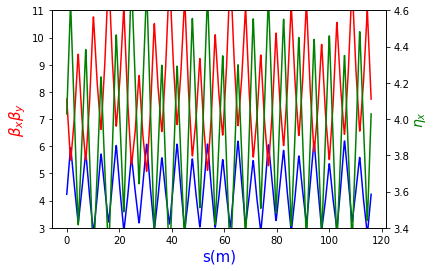

In [11]:
twiss_error = getOptics(ring, '*', 'beta', 'True')

In [16]:
#Cell2

In [12]:
# ORM Cx, Cy

Cxx_err, Cxy_err= ORM_x_error(1.e-4, ring)
Cyy_err, Cyx_err= ORM_y_error(1.e-4, ring)

print(shape(Cxx_err))

(40, 40)


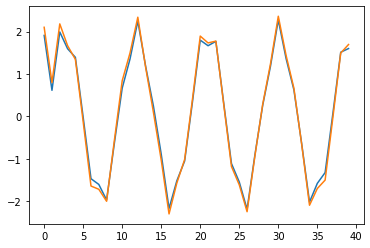

In [13]:
plt.plot(Cxx_err[1])
plt.plot((Cxx[1]))
plt.show()
#plt.imshow(Cxx_err)
plt.show()

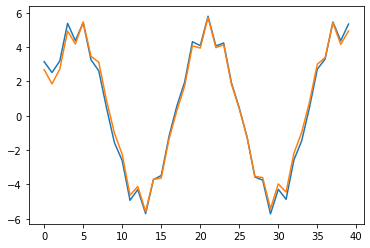

In [14]:
plt.plot(Cyy[1])
plt.plot((Cyy_err[1]))
plt.show()
#plt.imshow(Cyy_err)

In [15]:
print(np.max(Cyy_err-Cyy))

0.5604366124696254


In [22]:
#Cell4

In [16]:
#A, B = build_matrix(ormx, ormy, C0x, C0x, C0x, dCx, dCy, dCxy, Cyx, ormx, ormy)


Nk = len(dCx) #number of free parameters (number of quads or g_k)
Nm = 40 # number of measurements (iteration) ######### #######
print('NK:', Nk)
print('Nm:', Nm)

Ax = np.zeros([Nk,Nk])
Ay = np.zeros([Nk,Nk])
Axy = np.zeros([Nk,Nk])
Ayx = np.zeros([Nk,Nk])

A = np.zeros([4*Nk,Nk]) # (160, 40) ###########


NK: 40
Nm: 40


In [17]:
Bx = np.zeros([Nk,1])
By = np.zeros([Nk,1])
Bxy = np.zeros([Nk,1])
Byx = np.zeros([Nk,1])

B = np.zeros([4*Nk,1])


In [18]:
Dx = (Cxx_err[0:Nm,:] - C0x[0:Nm,:]) ### dk ?
Dy = (Cyy_err[0:Nm,:] - C0y[0:Nm,:])
Dxy = (Cxy_err[0:Nm,:] - C0xy[0:Nm,:])
Dyx = (Cyx_err[0:Nm,:] - C0yx[0:Nm,:])

In [19]:
for i in range(Nk): ## i represents each quad
    #print('done A:', 100.* i ,'%')
    for j in range(Nk):
        Ax[i,j] = np.sum(np.dot(dCx[i],dCx[j].T) )
        Ay[i,j] = np.sum(np.dot(dCy[i],dCy[j].T) )
        Axy[i,j] = np.sum(np.dot(dCxy[i],dCxy[j].T) )
        Ayx[i,j] = np.sum(np.dot(dCyx[i],dCyx[j].T) )
    A[i,:] = Ax[i,:]
    A[i+Nk,:] = Ay[i,:]
    A[i+2*Nk,:] = Axy[i,:]
    A[i+3*Nk,:] = Ayx[i,:]

In [20]:
for i in range(Nk):
    Bx[i] = np.sum( np.dot(dCx[i], Dx.T) )
    By[i] = np.sum( np.dot(dCy[i], Dy.T) )
    Bxy[i] = np.sum( np.dot(dCxy[i], Dxy.T) )
    Byx[i] = np.sum( np.dot(dCyx[i], Dyx.T) )
    B[i] = Bx[i]
    B[i+Nk] = By[i]
    B[i+2*Nk] = Bxy[i]
    B[i+3*Nk] = Byx[i]

number of singular values 40
A(160, 40) B(160, 1) U(160, 160) smat(160, 40) v(40, 40)


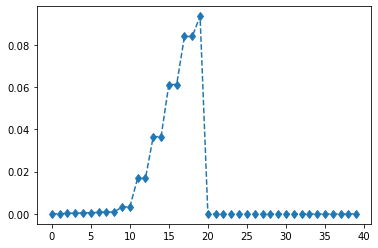

In [21]:
u,s,v=np.linalg.svd(A,  full_matrices=True)

smat = 0.0 * A
si = s**-1
n_sv = 20
si[n_sv:] *= 0.0

print("number of singular values {}".format(len(si)))
smat[:Nk,:Nk] = np.diag(si)


print('A'+str(A.shape), 'B'+str(B.shape),'U'+str(u.shape), 'smat'+str(smat.shape), 'v'+str(v.shape))


plt.plot(si,'d--')
plt.show()

In [22]:
si

array([6.17632595e-05, 6.17632595e-05, 2.94482792e-04, 2.94482792e-04,
       5.23552778e-04, 5.23552778e-04, 7.77750310e-04, 8.99467771e-04,
       8.99467771e-04, 3.31811094e-03, 3.31811094e-03, 1.68181606e-02,
       1.68181606e-02, 3.65307966e-02, 3.65307966e-02, 6.11911631e-02,
       6.11911632e-02, 8.38986064e-02, 8.38986064e-02, 9.34730219e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

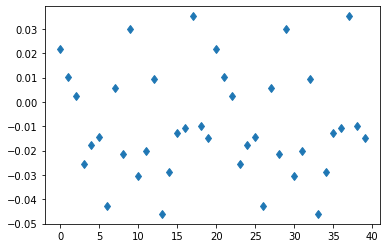

In [23]:
Ai=np.dot(v.transpose(),np.dot(smat.transpose(),u.transpose()))

###
r = ( np.dot(Ai,B)).reshape(-1)
plot(r,'d')
plt.show()

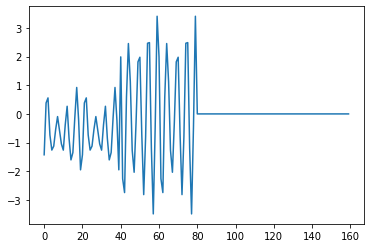

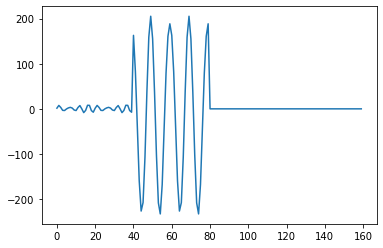

In [24]:
# error
e = np.dot(A,r).reshape(-1) - B.reshape(-1)
plt.plot(e)
plt.show()
plt.plot(B)
plt.show()

In [25]:
quad_dict,quad_vals = getQuadFamilies(quads_info_error)
quads = [ k for k in quad_dict.keys()]
print(f"Quadrupoles:{quads}")
iq = 1
print(quads[iq], quad_dict[quads[iq]])
print(quad_vals[quads[iq],1])
print(quad_vals[quads[iq],1])
eocc_a, vals = getQuadFamilies(quads_info_error)
print(eocc_a)
print(quad_vals[quads[iq],1])

Quadrupoles:['QF', 'QD']
QD 20
-2.120518683609408
-2.120518683609408
{'QF': 20, 'QD': 20}
-2.120518683609408


In [26]:
# check correction...


n_list = len(quads_info_error.s_pos)
print(n_list)

quad_names = quad_names
iq = 0
frac = 1.0
cor_dict = {}
for qname in quad_names:
    nquad = quad_dict[qname]
    #print(qname, quad_dict[qname])
    for i in range(0, nquad):
        cor_dict[qname, i+1] = -r[iq]*frac
        iq += 1

40


In [27]:
DK = []
for idx in range(n_list):
   qname_ = quads_info.elements_name[idx]  # ElementName

   if qname_ == 'QF':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QF',occ]
      DK.append(dk)

   if qname_ == 'QD':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QD',occ]
      DK.append(dk)

In [28]:
quads_indexes = get_refpts(ring, elements.Quadrupole)
i = 0
while (i < len(quads_indexes)):

      print(ring[quads_indexes[i]].K)
      ring[quads_indexes[i]].K += DK[i]
      print(ring[quads_indexes[i]].K)
      i += 1


1.8211850718031566
1.7994709381308098
-2.120518683609408
-2.1422328172817564
1.76946714438581
1.7592044023175837
-2.1224131680641247
-2.132675910132351
1.7580749954524142
1.7555576110965243
-2.1354312892622263
-2.1379486736181144
1.7576848844995816
1.7832089852216917
-2.1893168565862497
-2.1637927558641383
1.7230604279467185
1.7406586174864198
-2.1061185204209787
-2.0885203308812743
1.7596380471436837
1.774119084479239
-2.1943327991653896
-2.179851761829826
1.7245614422355573
1.7672574864512505
-2.1201777270478983
-2.07748168283222
1.7763812951741789
1.7706053538826303
-2.1680231505608774
-2.1737990918524304
1.7764637691352307
1.7979734693452645
-2.145762288037714
-2.1242525878276863
1.8072031360375185
1.7773388091846059
-2.134226846890023
-2.164091173742935
1.7449602137537956
1.7751918298837273
-2.1875552281735455
-2.1573236120436152
1.7644494765702037
1.7847518089463676
-2.123265371421942
-2.1029630390457816
1.7608591290925122
1.7514938757621288
-2.1387954318744047
-2.148160685204787

preparing twiss ..
Tunes=[0.40613756 0.35704541]
Chrom=[-2.71440218 -1.97038087]


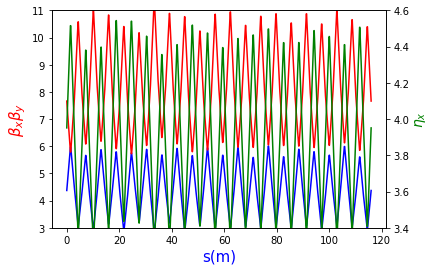

In [29]:
twiss_corrected = getOptics(ring, '*', 'beta', 'True')

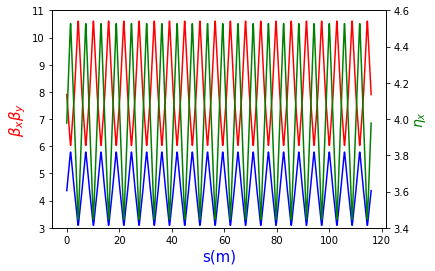

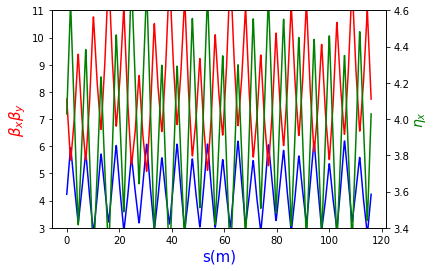

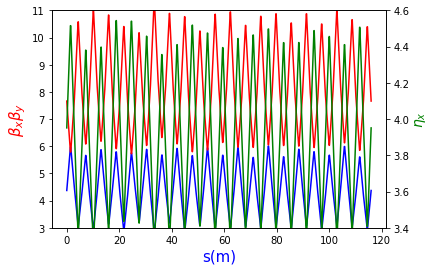

In [30]:
fig, ax = plt.subplots()
ax.plot(twiss.s_pos,  twiss.betax, color="blue")
ax.plot(twiss.s_pos,  twiss.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)

# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(twiss.s_pos, twiss.dx, color="green")
ax2.set_ylabel(r'$\eta_x$', color="green", fontsize=14)
ax2.set_ylim([3.4, 4.6])
plt.show()




fig, ax = plt.subplots()
ax.plot(twiss_error.s_pos,  twiss_error.betax, color="blue")
ax.plot(twiss_error.s_pos,  twiss_error.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)

# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(twiss_error.s_pos, twiss_error.dx, color="green")
ax2.set_ylabel(r'$\eta_x$', color="green", fontsize=14)
ax2.set_ylim([3.4, 4.6])
plt.show()



fig, ax = plt.subplots()
ax.plot(twiss_corrected.s_pos,  twiss_corrected.betax, color="blue")
ax.plot(twiss_corrected.s_pos,  twiss_corrected.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)

# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(twiss_corrected.s_pos, twiss_corrected.dx, color="green")
ax2.set_ylabel(r'$\eta_x$', color="green", fontsize=14)
ax2.set_ylim([3.4, 4.6])
plt.show()

In [31]:
twiss_error

,s_pos,betax,betay,dx,dy
0,0.0,4.233242,7.734933,4.028498,0.430659
1,1.3,5.814816,5.636163,4.584551,0.417760
2,1.3,5.814816,5.636163,4.584551,0.417760
3,1.4,5.932288,5.509863,4.626327,0.417760
4,1.4,5.932288,5.509863,4.626327,0.417760
...,...,...,...,...,...
276,114.5,2.812769,10.970468,3.440294,-0.346656
277,114.5,2.812769,10.970468,3.440294,-0.346656
278,114.6,2.819067,10.944012,3.443026,0.401401
279,114.7,2.894179,10.682159,3.483166,0.401401


In [33]:
twiss_corrected

,s_pos,betax,betay,dx,dy
0,0.0,4.267493,7.998009,3.934993,0.406422
1,1.3,5.522167,6.273009,4.464630,0.401692
2,1.3,5.522167,6.273009,4.464630,0.401692
3,1.4,5.613311,6.168919,4.504799,0.401692
4,1.4,5.613311,6.168919,4.504799,0.401692
...,...,...,...,...,...
276,114.5,3.088129,10.618938,3.386922,-0.347901
277,114.5,3.088129,10.618938,3.386922,-0.347901
278,114.6,3.081349,10.627973,3.388093,0.371368
279,114.7,3.146833,10.413559,3.425230,0.371368
